# Benchmark - Energy Conversation

This notebook allows you to reproduce the comparisons between the Sheet Model and the GNS in terms of Energy Conservation.


**Note**: It takes a considerable amount of time to run these tests

**Requirements**: Download Datasets + Pre-trained Models

In [1]:
import os
import jax
import sys
import glob
import pickle
import numpy as np

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

from pathlib import Path
from tqdm.auto import tqdm

sys.path.append('../..')
from gns.simulator import SMGNS
from gns.preprocess import init_GNS_as_SM
from sheet_model.synchronous import SyncSheetModel
from sheet_model.modified import ModSyncSheetModel
from sheet_model.utils import get_dx_eq, get_x_eq, moving_average, get_max_dE


## OPTIONAL: dont let JAX preallocate all GPU memory + free unused arrays 
## https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
## makes code slower
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
def energy_cons_sm(lambda_v, opt, modified=False):
    """
    Aux function to compute energy conservation of sheet model.
    
    Args:
        lambda_v - function that generates array of input velocities
        opt - sheet model simulation parameters
        modified - use modified sync implementation
        
    Returns:
        results - dict with dE mean + std over multiple simulations
    """
    results = {'mean': [], 'std': []}
    
    # reproducibility + same random as GNN
    np.random.seed(42) 

    # store only every dt=1e-1
    dt_undersample = max(1, np.ceil(dt/1e-1))
    
    if modified:
        sim = ModSyncSheetModel(**opt)
    else:
        sim = SyncSheetModel(**opt)
                 
    for v_th in V_TH:

        print('v_th:', v_th)
        
        dE = []
        
        for i in tqdm(range(N_SIMULATIONS)):
            
            v0 = lambda_v(v_th)
            
            _, _, _, E = sim.run_simulation(x_0=x0,
                                            v_0=v0,
                                            x_eq_0=x_eq,
                                            t_max=t_max,
                                            dt_undersample=dt_undersample,
                                            verbose=False)


            dE.append(get_max_dE(E, 
                                 dt=dt*dt_undersample,
                                 w_ma=2*np.pi,
                                 t_skip=2*np.pi))

        results['mean'].append(np.mean(dE))
        results['std'].append(np.std(dE))
        
    return results


def energy_cons_gns(lambda_v, opt):
    """
    Aux function to compute energy conservation of GNS.
    
    Args:
        lambda_v - function that generates array of input velocities
        opt - sheet model simulation parameters
        
    Returns:
        results - dict with dE mean + std over multiple simulations
    """
    results = dict()
    
    for model in glob.glob('../../models/final/dt{0:.0e}/[0-9]'.format(dt).replace('e-0', 'e-')):
        
        print('model:', model)
        gns = SMGNS(model, opt['boundary'], verbose=False)
        
        imodel = model.split('/')[-1]            
        results[imodel] = {'mean': [], 'std': []}

        for v_th in V_TH:

            print('v_th:', v_th)
            dE = []

            # same random as Sheet Model + other GNS models
            np.random.seed(42)

            for i in tqdm(range(N_SIMULATIONS)):

                x0 = x_eq.copy()
                v0 = lambda_v(v_th)
                
                # very important to ensure we are modeling the same system!
                x0, v0, x_eq0, E0 = init_GNS_as_SM(x0,
                                                   v0,
                                                   x_eq,
                                                   gns=gns,
                                                   n_guards=opt['n_guards'])

                _, _, _, E = gns.pred_rollout(x0, 
                                              v0,
                                              x_eq,
                                              t_max=t_max,
                                              n_guards=0,
                                              verbose=False,
                                              track_sheets=False,
                                              np_=np)



                dE.append(get_max_dE(E, 
                                     dt=gns.dt_train, 
                                     E0=E0,
                                     w_ma=2*np.pi,
                                     t_skip=2*np.pi))

            results[imodel]['mean'].append(np.mean(dE))
            results[imodel]['std'].append(np.std(dE))
        
    return results

## Simulation Parameters

In [3]:
# ----------------------------------
# Default Options
opt = {
    'n_guards' : 50, # number of guards
    'n_sheets' : 1000, #number of sheets
    'boundary' : 'periodic', # type (periodic or reflecting)
    'n_it_crossings' : None, # number of iterations used to solve crossings
    'track_sheets': False,
    'L': 1,
    'dt': None
}

t_max = 5*np.pi*2
dx_eq = get_dx_eq(opt['n_sheets'], opt['L']) 
x_eq = get_x_eq(opt['n_sheets'], opt['L'])
x0 = x_eq

N_SIMULATIONS = 1
V_TH = np.logspace(0,2,10) # V_0 values to check

lambda_v_thermal = lambda v_th : np.random.normal(0, v_th, opt['n_sheets']) * dx_eq

## Sheet Model (all thermal plasma)
### In function of n_it_crossings

In [4]:
results_nitc = dict()

for dt in [1e-1, 1e-2]:
    dt_undersample = int(1e-1/dt)
    results_nitc[dt] = dict()
    for n in np.arange(4):
        print(dt, n)
        aux = opt.copy()
        aux['dt'] = dt
        aux['n_it_crossings'] = n
        results_nitc[dt][n] = energy_cons_sm(lambda_v_thermal, aux)

0.1 0
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.1 1
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.1 2
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.1 3
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.01 0
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.01 1
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.01 2
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.01 3
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

### In function of n_neighbors checked (modified SM)

In [5]:
results_neighbors = dict()

aux = opt.copy()
aux['n_it_crossings'] = 2

dt = 1e-1
results_neighbors[dt] = dict()
aux['dt'] = dt
for n in np.arange(1,9,2):
    print(dt, n)
    aux['n_max_neighbor'] = n
    results_neighbors[dt][n] = energy_cons_sm(lambda_v_thermal, aux, modified=True)
    
    
dt = 1e-2
results_neighbors[dt] = dict()
aux['dt'] = dt
for n in np.arange(1,4):
    print(dt, n)
    aux['n_max_neighbor'] = n
    results_neighbors[dt][n] = energy_cons_sm(lambda_v_thermal, aux, modified=True)

0.1 1
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.1 3
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.1 5
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.1 7
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.01 1
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.01 2
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.01 3
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
sorted(results_neighbors, reverse=True)

[0.1, 0.01]

## GNS

### Thermal

In [7]:
results_thermal = dict()
for dt in [1e-1, 1e-2]:
    print(dt)
    results_thermal[dt] = energy_cons_gns(lambda_v_thermal, opt)

0.1
model: ../../models/final/dt1e-1/4
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-1/2
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-1/0
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

2023-12-29 16:10:36.827443: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 52.733800696s
Constant folding an instruction is taking > 1s:

  slice.5 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-1/1
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-1/3
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.01
model: ../../models/final/dt1e-2/4
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-2/0
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-2/1
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-2/3
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

### Oscillations

In [8]:
results_osc = dict()
lambda_v_osc = lambda v_osc : np.ones(opt['n_sheets']) * v_osc * dx_eq

for dt in [1e-1, 1e-2]:
    print(dt)
    results_osc[dt] = energy_cons_gns(lambda_v_osc, opt)

0.1
model: ../../models/final/dt1e-1/4
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-1/2
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-1/0
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-1/1
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-1/3
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

0.01
model: ../../models/final/dt1e-2/4
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-2/2
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-2/0
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-2/1
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

model: ../../models/final/dt1e-2/3
v_th: 1.0


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 1.6681005372000588


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 2.7825594022071245


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 4.641588833612778


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 7.742636826811269


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 12.91549665014884


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 21.544346900318832


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 35.93813663804626


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 59.94842503189409


  0%|          | 0/1 [00:00<?, ?it/s]

v_th: 100.0


  0%|          | 0/1 [00:00<?, ?it/s]

# Save files

In [9]:
with open('benchmark_energy.pkl', 'wb') as f:
    
    benchmark_energy = {
        'nitc': results_nitc,
        'neighbors': results_neighbors,
        'thermal': results_thermal,
        'osc': results_osc,
    }
    
    pickle.dump(benchmark_energy, f)

## Load files

In [10]:
with open('benchmark_energy.pkl', 'rb') as f:
    benchmark_energy = pickle.load(f)
    results_nitc = benchmark_energy['nitc']
    results_neighbors = benchmark_energy['neighbors']
    results_thermal = benchmark_energy['thermal']
    results_osc = benchmark_energy['osc']

# Plot results

In [11]:
colors = {1e-1: 'tab:blue', 1e-2: 'tab:orange'}
markers = {'sm': 'o', 'gns': 's'}
lstyles = {'msm': ':', 'sm': '--', 'gns': '-'}

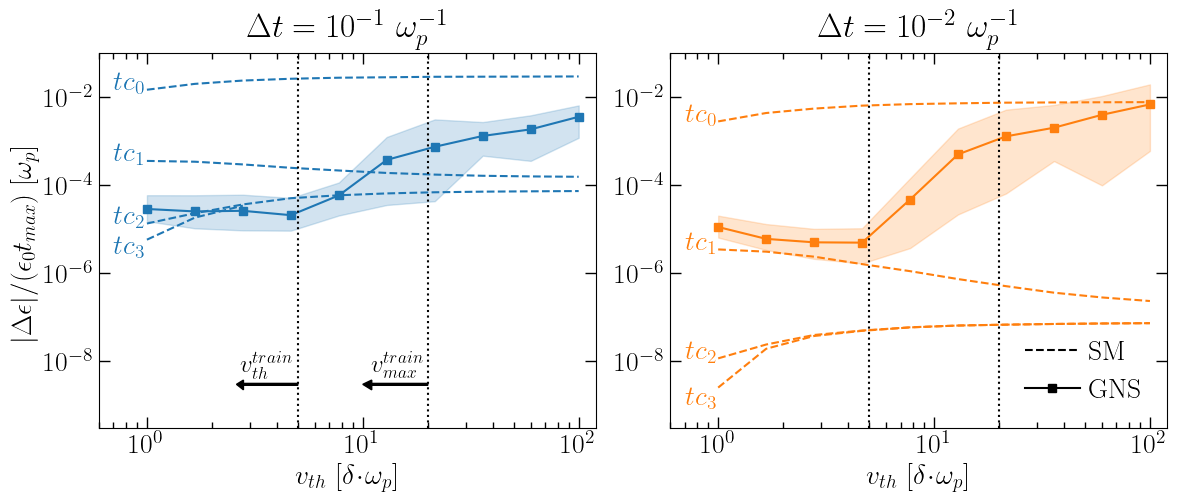

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=False,
                      gridspec_kw={'wspace': 0.15, 'bottom': 0.15, 'top': 0.9, 'left': 0.10, 'right': 0.99})


for i, dt in enumerate(sorted(results_nitc, reverse=True)):
    for nitc, r in results_nitc[dt].items():
        # to avoid dashed line becoming a full line
        if nitc == 3 and dt == 1e-1:
            ax[i].plot(V_TH[:3], np.array(r['mean'])[:3]/t_max, linestyle=lstyles['sm'], color=colors[dt])
        else:
            ax[i].plot(V_TH, np.array(r['mean'])/t_max, linestyle=lstyles['sm'], color=colors[dt])

    
for i, (dt, r) in enumerate(results_thermal.items()):
    r_mean = []
    r_std = []

    for imodel, rm in r.items():
        ## uncomment to remove model 4
        #if imodel != '4' or dt != 1e-2:
            r_mean.append(rm['mean'])
            r_std.append(rm['std'])

    r_mean = np.array(r_mean)/t_max 
    r_std = np.array(r_std)/t_max

    ax[i].fill_between(V_TH, np.min(r_mean, axis=0), np.max(r_mean, axis=0),
                       color=colors[dt], 
                       alpha=.2)

    ax[i].plot(V_TH, np.mean(r_mean, axis=0),
               marker=markers['gns'], linestyle=lstyles['gns'], color=colors[dt])
    
    
plt.setp(ax, xscale='log')
plt.setp(ax, yscale='log')


plt.setp(ax, xlabel='$v_{th}$ $[\delta\!\cdot\!\omega_p]$')
ax[0].set_ylabel('$|\Delta\epsilon|/(\epsilon_0 t_{max}$) [$\omega_p$]')
ax[0].set_title('$\Delta t = 10^{-1} \ \omega_p^{-1}$', pad=12)
ax[1].set_title('$\Delta t = 10^{-2} \ \omega_p^{-1}$', pad=12)
plt.setp(ax, ylim = (3e-10, 1e-1))
plt.setp(ax, xlim = (0.6, 120))

handles = []
handles.append(mlines.Line2D([], [], color='k', linestyle=lstyles['sm'], marker=None, label='SM'))
handles.append(mlines.Line2D([], [], color='k', linestyle=lstyles['gns'], marker=markers['gns'], label='GNS'))
ax[1].legend(handles=handles, loc='lower right')
#plt.savefig('../img/benchmark_energy_wosc.pdf')

ax[0].text(.7, results_nitc[1e-1][0]['mean'][0]/t_max, '$tc_0$', fontsize=20, color='tab:blue') 
ax[0].text(.7, results_nitc[1e-1][1]['mean'][0]/t_max, '$tc_1$', fontsize=20, color='tab:blue') 
ax[0].text(.7, results_nitc[1e-1][2]['mean'][0]/t_max, '$tc_2$', fontsize=20, color='tab:blue') 
ax[0].text(.7, results_nitc[1e-1][3]['mean'][0]/t_max - 3e-6, '$tc_3$', fontsize=20, color='tab:blue')

ax[1].text(.7, results_nitc[1e-2][0]['mean'][0]/t_max, '$tc_0$', fontsize=20, color='tab:orange') 
ax[1].text(.7, results_nitc[1e-2][1]['mean'][0]/t_max, '$tc_1$', fontsize=20, color='tab:orange') 
ax[1].text(.7, results_nitc[1e-2][2]['mean'][0]/t_max, '$tc_2$', fontsize=20, color='tab:orange') 
ax[1].text(.7, results_nitc[1e-2][3]['mean'][0]/t_max - 1.5e-9, '$tc_3$', fontsize=20, color='tab:orange')


for a in ax:
    a.axvline(20, ls=':', color='k')
    a.axvline(5, ls=':', color='k')
    a.tick_params(axis='y', which='minor', left=False, right=False)

ax[0].arrow(20, 3*10**-9., -9, 0, width=0.3*10**-9, head_width=1.5*10**-9, head_length=1, color='k')
ax[0].arrow(5, 3*10**-9., -2.2, 0, width=0.3*10**-9, head_width=1.5*10**-9, head_length=.2, color='k')
ax[0].text(10.9, 6*10**-9, '$v_{max}^{train}$', fontsize=18)
ax[0].text(2.7, 6*10**-9, '$v_{th}^{train}$', fontsize=18)

plt.savefig('../img/benchmark_energy_ntc.pdf')
plt.show()

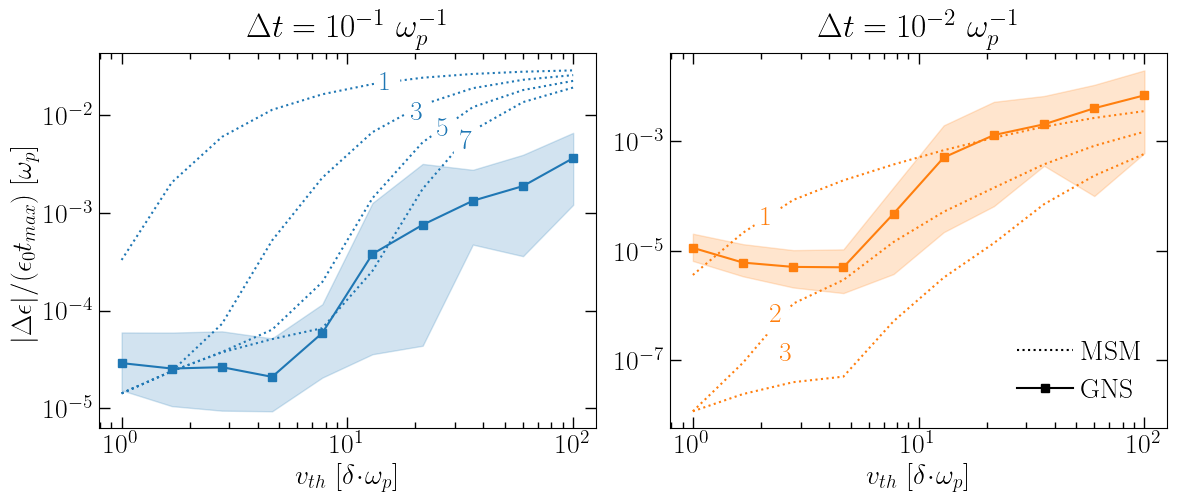

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=False,
                      gridspec_kw={'wspace': 0.15, 'bottom': 0.15, 'top': 0.9, 'left': 0.10, 'right': 0.99})


for i, dt in enumerate(sorted(results_neighbors, reverse=True)):
    for n, r in results_neighbors[dt].items():
        ax[i].plot(V_TH, np.array(r['mean'])/t_max,
                   marker=None, linestyle=lstyles['msm'], color=colors[dt])

    
for i, (dt, r) in enumerate(results_thermal.items()):
    r_mean = []
    r_std = []

    for imodel, rm in r.items():
        #if imodel != '4' or dt != 1e-2:
            r_mean.append(rm['mean'])
            r_std.append(rm['std'])

    r_mean = np.array(r_mean)/t_max
    r_std = np.array(r_std)/t_max
    
    ax[i].fill_between(V_TH, np.min(r_mean, axis=0), np.max(r_mean, axis=0),
                       color=colors[dt], 
                       alpha=.2)

    ax[i].plot(V_TH, np.mean(r_mean, axis=0),
               marker=markers['gns'], linestyle=lstyles['gns'], color=colors[dt])
    
    
plt.setp(ax, xscale='log')
plt.setp(ax, yscale='log')


plt.setp(ax, xlabel='$v_{th}$ $[\delta\!\cdot\!\omega_p]$')
ax[0].set_ylabel('$|\Delta\epsilon|/(\epsilon_0 t_{max}$) [$\omega_p$]')
ax[0].set_title('$\Delta t = 10^{-1} \ \omega_p^{-1}$', pad=12)
ax[1].set_title('$\Delta t = 10^{-2} \ \omega_p^{-1}$', pad=12)
#plt.ylim(1e-8, 1e-1)
 

handles = []
handles.append(mlines.Line2D([], [], color='k', linestyle=lstyles['msm'], marker=None, label='MSM'))
handles.append(mlines.Line2D([], [], color='k', linestyle=lstyles['gns'], marker=markers['gns'], label='GNS'))
ax[1].legend(handles=handles, loc='lower right')

ax[0].tick_params(axis='y', which='minor', left=False, right=False)
ax[1].tick_params(axis='y', which='minor', left=False, right=False)

ax[0].text(14, 1.8e-2, '1', fontsize=20, color='tab:blue', fontweight='extra bold', bbox={'color': 'white'}, ma='center') 
ax[0].text(19, 9e-3, '3', fontsize=20, color='tab:blue', fontweight='extra bold', bbox={'color': 'white'}) 
ax[0].text(25, 6.2e-3, '5', fontsize=20, color='tab:blue', fontweight='extra bold', bbox={'color': 'white'}) 
ax[0].text(31.5, 4.5e-3, '7', fontsize=20, color='tab:blue', fontweight='extra bold', bbox={'color': 'white'})

ax[1].text(2, 3e-5, '1', fontsize=20, color='tab:orange', fontweight='extra bold', bbox={'color': 'white'}, ma='center') 
ax[1].text(2.2, 5e-7, '2', fontsize=20, color='tab:orange', fontweight='extra bold', bbox={'color': 'white'}) 
ax[1].text(2.4, 1e-7, '3', fontsize=20, color='tab:orange', fontweight='extra bold', bbox={'color': 'white'}) 

plt.savefig('../img/benchmark_energy_neighbors.pdf')
plt.show()

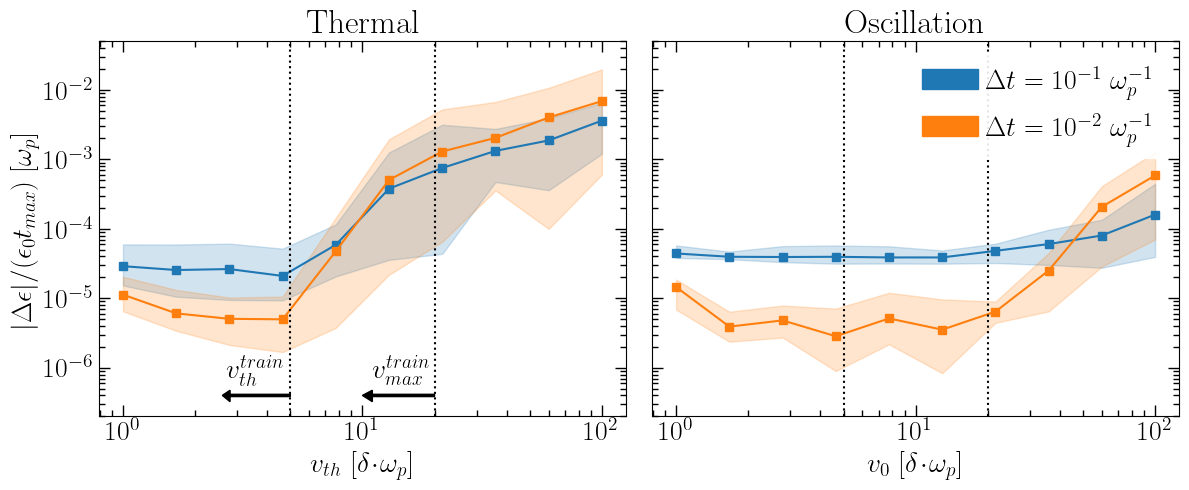

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True, sharey=True, 
                       gridspec_kw={'wspace': 0.05, 'bottom': 0.15, 'top': 0.90, 'left': 0.09, 'right': 0.99})


########## thermal plasma

for dt, r in results_thermal.items():
    r_mean = []
    r_std = []

    for imodel, rm in r.items():
         #if imodel != '4' or dt != 1e-2:
            r_mean.append(rm['mean'])
            r_std.append(rm['std'])

    r_mean = np.array(r_mean)/t_max
    r_std = np.array(r_std)/t_max

    ax[0].fill_between(V_TH, np.min(r_mean, axis=0), np.max(r_mean, axis=0),
                     color=colors[dt], alpha=.2)

    ax[0].plot(V_TH, np.mean(r_mean, axis=0), 
               marker=markers['gns'], linestyle=lstyles['gns'], color=colors[dt])
    

######### oscilation

for dt, r in results_osc.items():
    r_mean = []
    r_std = []

    for imodel, rm in r.items():
         #if imodel != '4' or dt != 1e-2:
            r_mean.append(rm['mean'])
            r_std.append(rm['std'])

    r_mean = np.array(r_mean)/t_max
    r_std = np.array(r_std)/t_max

    ax[1].fill_between(V_TH, np.min(r_mean, axis=0), np.max(r_mean, axis=0),
                     color=colors[dt], alpha=.2)

    ax[1].plot(V_TH, np.mean(r_mean, axis=0), 
               marker=markers['gns'], linestyle=lstyles['gns'], color=colors[dt])
    


for a in ax:
    a.axvline(20, ls=':', color='k')
    a.axvline(5, ls=':', color='k')

ax[0].arrow(20, 4*10**-7., -9, 0, width=0.3*10**-7, head_width=1.5*10**-7, head_length=1, color='k')
ax[0].arrow(5, 4*10**-7, -2.2, 0, width=0.3*10**-7, head_width=1.5*10**-7, head_length=.2, color='k')
ax[0].text(11, 7*10**-7, '$v_{max}^{train}$', fontsize=20)
ax[0].text(2.7, 7*10**-7, '$v_{th}^{train}$', fontsize=20)

ax[0].set_title('Thermal')
ax[1].set_title('Oscillation')

ax[0].set_xlabel('$v_{th}$ [$\delta\!\cdot\!\omega_p$]')
ax[1].set_xlabel('$v_{0}$ [$\delta\!\cdot\!\omega_p$]')
ax[0].set_ylabel('$|\Delta\epsilon|/(\epsilon_0 t_{max}$) [$\omega_p$]')


handles = [mpatches.Patch(color=c, label='$\Delta t = 10^{{{:.0f}}}~\omega_p^{{-1}}$'.format(np.log10(dt))) for dt, c in colors.items()]
ax[1].legend(handles=handles, framealpha=0.9, loc='upper right')

plt.yscale('log')
plt.xscale('log')

plt.ylim(2e-7, 5e-2)
plt.savefig('../img/benchmark_energy_wosc.pdf')
plt.show()

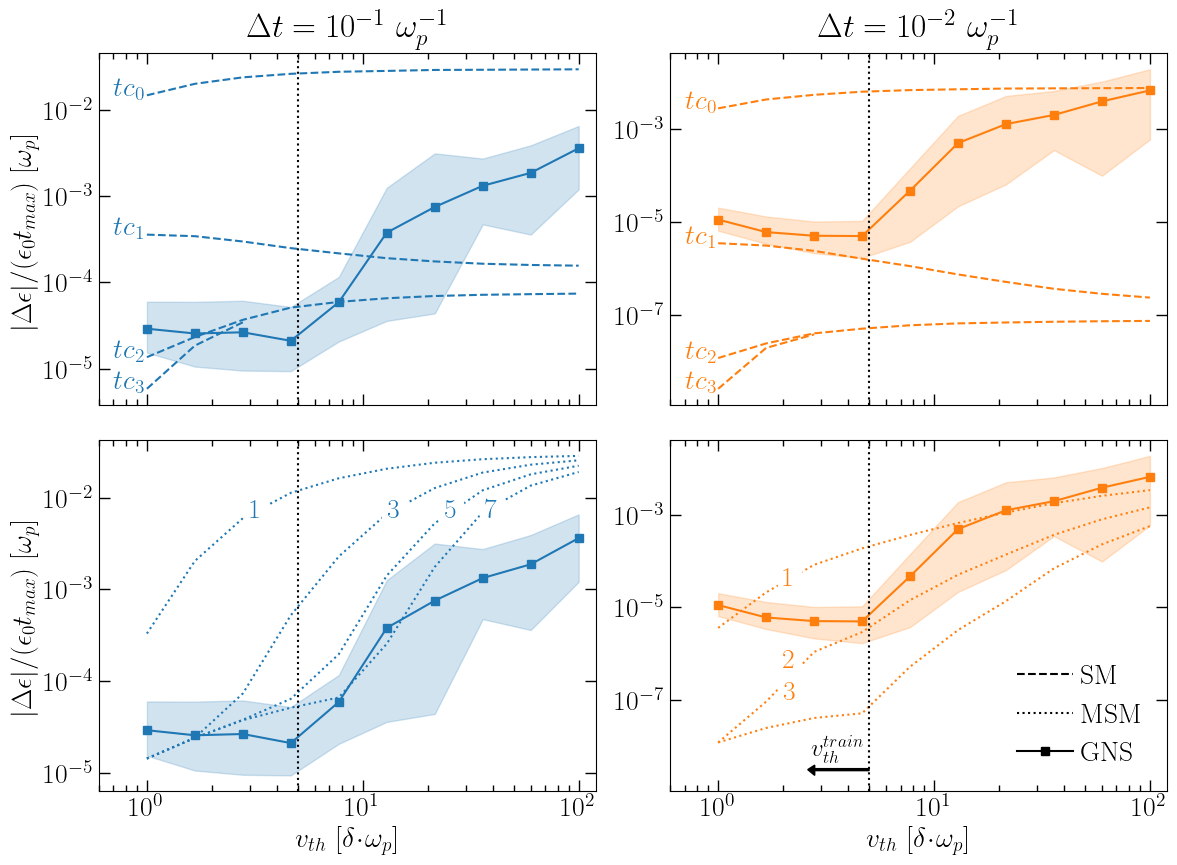

In [15]:
fig, ax = plt.subplots(2,2, figsize=(12, 9), sharex=True, sharey=False,
                      gridspec_kw={'wspace': 0.15, 'hspace': 0.10,
                                   'bottom': 0.1, 'top': 0.92, 'left': 0.10, 'right': 0.99})


########## gns

for i, (dt, r) in enumerate(results_thermal.items()):
    r_mean = []
    r_std = []

    for imodel, rm in r.items():
        ## uncomment to remove model 4
        #if imodel != '4' or dt != 1e-2:
            r_mean.append(rm['mean'])
            r_std.append(rm['std'])

    r_mean = np.array(r_mean)/t_max 
    r_std = np.array(r_std)/t_max

    for a in ax:
        a[i].fill_between(V_TH, np.min(r_mean, axis=0), np.max(r_mean, axis=0),
                              color=colors[dt], 
                              alpha=.2)

        a[i].plot(V_TH, np.mean(r_mean, axis=0),
                   marker=markers['gns'], linestyle=lstyles['gns'], color=colors[dt])

    

########### sm

for i, dt in enumerate(sorted(results_nitc, reverse=True)):
    for nitc, r in results_nitc[dt].items():
        # to avoid dashed line becoming a full line
        if nitc == 3:
            ax[0, i].plot(V_TH[:3], np.array(r['mean'])[:3]/t_max, linestyle=lstyles['sm'], color=colors[dt])
        else:
            ax[0, i].plot(V_TH, np.array(r['mean'])/t_max, linestyle=lstyles['sm'], color=colors[dt])


ax[0,0].text(.7, results_nitc[1e-1][0]['mean'][0]/t_max, '$tc_0$', fontsize=20, color='tab:blue') 
ax[0,0].text(.7, results_nitc[1e-1][1]['mean'][0]/t_max, '$tc_1$', fontsize=20, color='tab:blue') 
ax[0,0].text(.7, results_nitc[1e-1][2]['mean'][0]/t_max, '$tc_2$', fontsize=20, color='tab:blue') 
ax[0,0].text(.7, results_nitc[1e-1][3]['mean'][0]/t_max, '$tc_3$', fontsize=20, color='tab:blue')

ax[0,1].text(.7, results_nitc[1e-2][0]['mean'][0]/t_max, '$tc_0$', fontsize=20, color='tab:orange') 
ax[0,1].text(.7, results_nitc[1e-2][1]['mean'][0]/t_max, '$tc_1$', fontsize=20, color='tab:orange') 
ax[0,1].text(.7, results_nitc[1e-2][2]['mean'][0]/t_max, '$tc_2$', fontsize=20, color='tab:orange') 
ax[0,1].text(.7, results_nitc[1e-2][3]['mean'][0]/t_max, '$tc_3$', fontsize=20, color='tab:orange')

handles = []
handles.append(mlines.Line2D([], [], color='k', linestyle=lstyles['sm'], marker=None, label='SM'))
handles.append(mlines.Line2D([], [], color='k', linestyle=lstyles['msm'], marker=None, label='MSM'))
handles.append(mlines.Line2D([], [], color='k', linestyle=lstyles['gns'], marker=markers['gns'], label='GNS'))
ax[1,1].legend(handles=handles, loc='lower right')


########## msm

for i, dt in enumerate(sorted(results_neighbors, reverse=True)):
    for n, r in results_neighbors[dt].items():
        ax[1,i].plot(V_TH, np.array(r['mean'])/t_max,
                     marker=None, linestyle=lstyles['msm'], color=colors[dt])


#ax[1,0].text(14, 1.8e-2, '1', fontsize=20, color='tab:blue', bbox={'color': 'white'}, ma='center') 
#ax[1,0].text(19, 9e-3, '3', fontsize=20, color='tab:blue',  bbox={'color': 'white'}) 
#ax[1,0].text(25, 6.2e-3, '5', fontsize=20, color='tab:blue',  bbox={'color': 'white'}) 
#ax[1,0].text(31.5, 4.5e-3, '7', fontsize=20, color='tab:blue',  bbox={'color': 'white'})
ax[1,0].text(3, 6e-3, '1', fontsize=20, color='tab:blue', bbox={'color': 'white'}, ma='center') 
ax[1,0].text(13, 6e-3, '3', fontsize=20, color='tab:blue',  bbox={'color': 'white'}) 
ax[1,0].text(24, 6e-3, '5', fontsize=20, color='tab:blue',  bbox={'color': 'white'}) 
ax[1,0].text(37, 6e-3, '7', fontsize=20, color='tab:blue',  bbox={'color': 'white'})

ax[1,1].text(2, 3e-5, '1', fontsize=20, color='tab:orange',  bbox={'color': 'white'}, ma='center') 
ax[1,1].text(2, 5e-7, '2', fontsize=20, color='tab:orange',  bbox={'color': 'white'}) 
ax[1,1].text(2, 1e-7, '3', fontsize=20, color='tab:orange',  bbox={'color': 'white'}) 

########### all

for a in ax.ravel():
#    a.axvline(20, ls=':', color='k')
    a.axvline(5, ls=':', color='k')
    a.tick_params(axis='y', which='minor', left=False, right=False)

ax[1,1].arrow(5, 3*10**-9., -2.2, 0, width=0.3*10**-9, head_width=1.5*10**-9, head_length=.2, color='k')
ax[1,1].text(2.7, 6*10**-9, '$v_{th}^{train}$', fontsize=18)


ax[0,0].set_title('$\Delta t = 10^{-1} \ \omega_p^{-1}$', pad=12)
ax[0,1].set_title('$\Delta t = 10^{-2} \ \omega_p^{-1}$', pad=12)

plt.setp(ax, xscale='log')
plt.setp(ax, yscale='log')
#plt.setp(ax, ylim = (3e-10, 1e-1))
plt.setp(ax, xlim = (0.6, 120))

ax[1,0].set_xlabel('$v_{th}$ [$\delta\!\cdot\!\omega_p$]')
ax[1,1].set_xlabel('$v_{th}$ [$\delta\!\cdot\!\omega_p$]')

ax[0,0].set_ylabel('$|\Delta\epsilon|/(\epsilon_0 t_{max}$) [$\omega_p$]')
ax[1,0].set_ylabel('$|\Delta\epsilon|/(\epsilon_0 t_{max}$) [$\omega_p$]')

plt.savefig('../img/benchmark_energy_comparison.pdf')
plt.show()

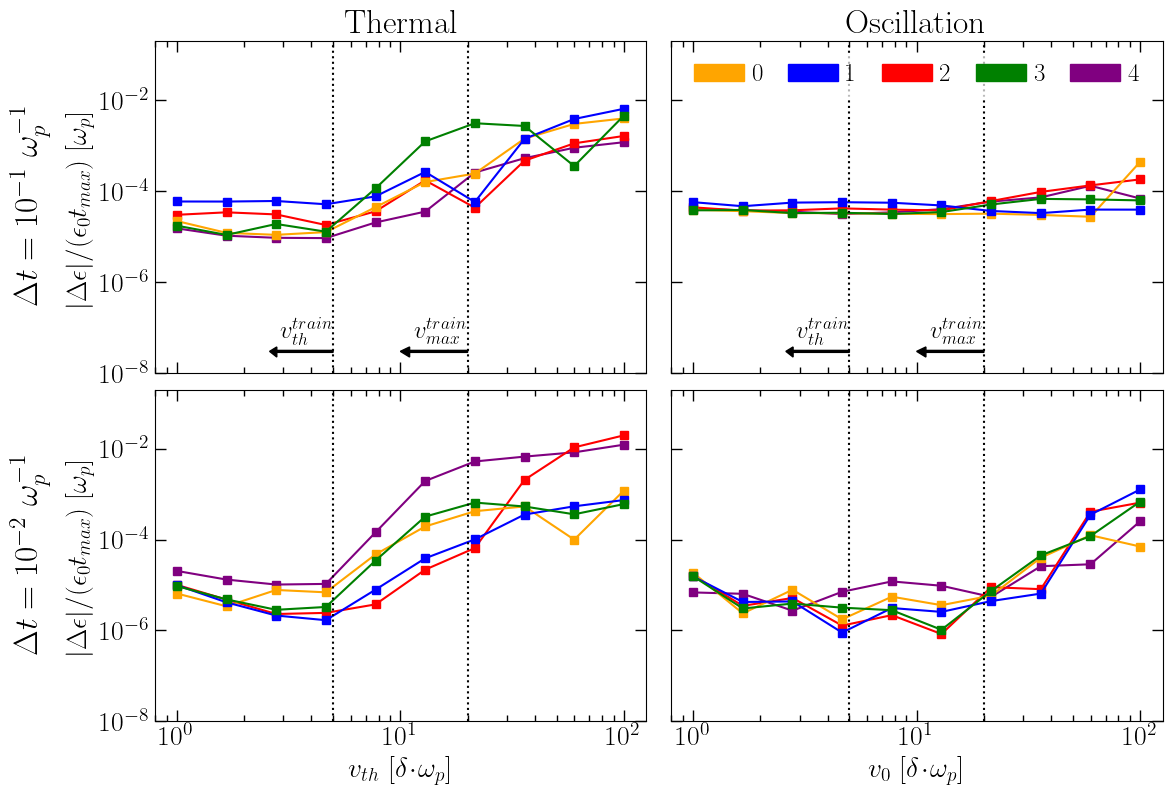

In [16]:
scolors = {'0': 'orange',
           '1': 'blue',
           '2': 'red',
           '3': 'green',
           '4': 'purple'}


fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True, 
                       gridspec_kw={'wspace': 0.05, 'bottom': 0.10, 'top': 0.95, 'left': 0.15, 'right': 0.99, 
                                    'hspace': 0.05})


########## thermal plasma
for idt, dt in enumerate(results_thermal):
    
    for imodel, rm in results_thermal[dt].items():
        ax[idt,0].plot(V_TH, np.array(rm['mean'])/t_max, 's-', color=scolors[imodel])
    for imodel, rm in results_osc[dt].items():
        ax[idt,1].plot(V_TH, np.array(rm['mean'])/t_max, 's-', color=scolors[imodel])
    



for a in ax.ravel():
    a.axvline(20, ls=':', color='k')
    a.axvline(5, ls=':', color='k')

for a in ax.T:
    a[0].arrow(20, 3*10**-8., -9, 0, width=0.3*10**-8, head_width=1.5*10**-8, head_length=1, color='k')
    a[0].arrow(5, 3*10**-8., -2.2, 0, width=0.3*10**-8, head_width=1.5*10**-8, head_length=.2, color='k')
    a[0].text(11.5, 6*10**-8, '$v_{max}^{train}$', fontsize=18)
    a[0].text(2.9, 6*10**-8, '$v_{th}^{train}$', fontsize=18)

ax[0,0].set_title('Thermal')
ax[0,1].set_title('Oscillation')

ax[-1,0].set_xlabel('$v_{th}$ [$\delta\!\cdot\!\omega_p$]')
ax[-1,1].set_xlabel('$v_{0}$ [$\delta\!\cdot\!\omega_p$]')

plt.setp(ax[:,0], ylabel ='$|\Delta\epsilon|/(\epsilon_0 t_{max}$) [$\omega_p$]')

handles = []
for seed, c in scolors.items():
    handles.append(mpatches.Patch(color=c, label=seed))

ax[0,1].legend(handles=handles, loc='upper center', ncol=5, columnspacing=1, fontsize=18)    

plt.yscale('log')
plt.xscale('log')

for a, j in zip(ax[:,0], [1,2]):
    a.text(0.22, 0.004, f'$\Delta t = 10^{{{-j}}} \ \omega_p^{{-1}}$',
           rotation=90,
           horizontalalignment='center',
           verticalalignment='center_baseline',
           multialignment='center',
           fontsize=24,
           fontweight='bold')

plt.ylim(1e-8, 2e-1)
plt.savefig('../img/benchmark_energy_all_seeds.pdf')
plt.show()

## Why the moving average is needed + ensuring the simulations initializations are equivalent?

In the example below, we will use the same initial velocities for both the SM and GNS (no correction for finite difference velocities)

In [17]:
opt = {
    'n_guards' : None, # number of guards
    'n_sheets' : 1000, #number of sheets
    'dt' : 1e-1, # simulation dt [1/w_p]
    'boundary' : 'periodic', # type (periodic or reflecting)
    'n_it_crossings' : 1, # number of iterations used to solve crossings
    'track_sheets': False,
    'L': 1
}

t_max = 100
dx_eq = get_dx_eq(opt['n_sheets']) 
x_eq = get_x_eq(opt['n_sheets'])
x0 = x_eq

model_folder = Path('../../models/final/dt1e-1/0/')
gns = SMGNS(model_folder, opt['boundary'], verbose=False)        

E_sm_hist = list()
E_gns_hist = list()

V_TH = [1, 5, 50]


for v_th in V_TH: 
    
    opt['n_guards'] = max(5, int(opt['dt'] * v_th * 10))
    sm = SyncSheetModel(**opt)
    
    print('v_th:', v_th)

    np.random.seed(42)
    
    x0 = x_eq.copy()
    v0 = np.random.normal(0, v_th, opt['n_sheets']) * dx_eq
    
    _, _, _, E_sm = sm.run_simulation(x_0=x0,
                                      v_0=v0,
                                      x_eq_0=x_eq,
                                      t_max=t_max,
                                      verbose=True)

    
    _, _, _, E_gns = gns.pred_rollout(x0, 
                                      v0,
                                      x_eq,
                                      t_max=t_max,
                                      verbose=True,
                                      np_=np)
    
    E_sm_hist.append(E_sm)
    E_gns_hist.append(E_gns)

v_th: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

v_th: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

v_th: 50


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



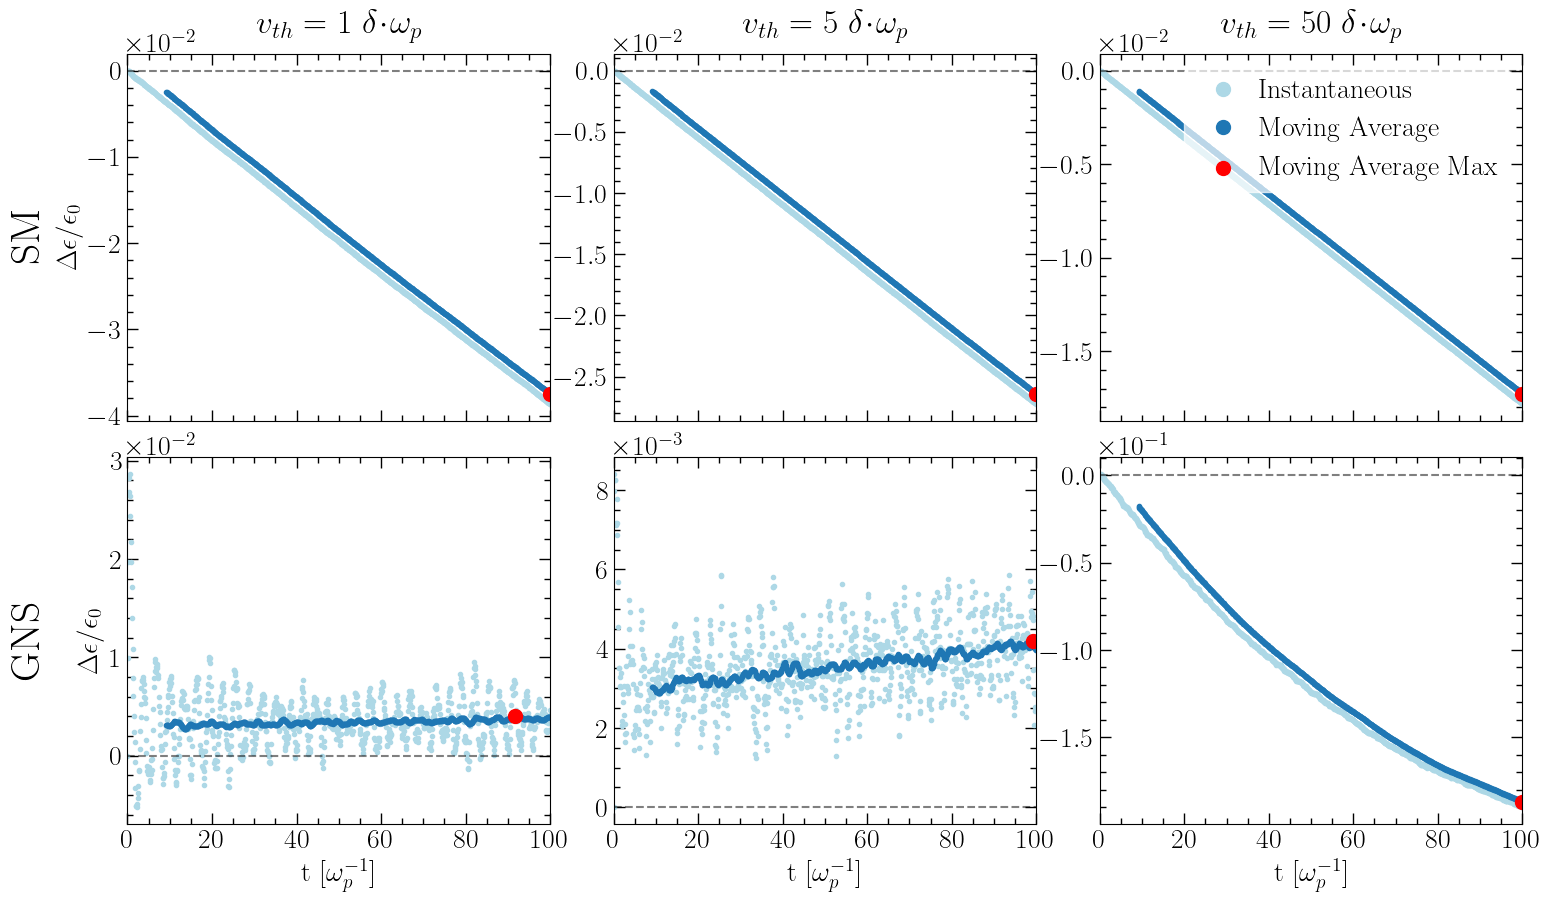

In [18]:
fig, ax = plt.subplots(2, len(V_TH), figsize=(6*len(V_TH),5*2),
                       gridspec_kw={'wspace':0.15, 'hspace':0.10}, sharex=True)

t = np.linspace(0,t_max, len(E_gns))
w_ma = int(2*np.pi/opt['dt'])
n_skip = int(np.pi/opt['dt'])

for im, (model, E_hist) in enumerate([['Sheet Model', E_sm_hist], ['GNS', E_gns_hist]]):
    for iv, E in enumerate(E_hist):
        
        E0 = E[0]
        E_ma = moving_average((E[n_skip:] - E0)/E0, w_ma) 

        E_ma_max = np.max(E_ma)
        E_ma_min = np.min(E_ma)

        ax[im, iv].plot(t, (E - E0)/E0, '.', c='lightblue', label='Instantaneous', rasterized=True)
        ax[im, iv].plot(t[w_ma-1 + n_skip:], E_ma, '.', label='Moving Average', rasterized=True)
        
        ax[im, iv].axhline(0, c='k', ls='--', alpha=0.5) 
        
        ax[im, iv].scatter(t[w_ma-1 + np.argmax(np.abs(E_ma)) + n_skip],
                           E_ma_max if E_ma_max > - E_ma_min else E_ma_min, 
                           c='r', s=100, label='Moving Average Max',
                           zorder=2)
        

for i, a in enumerate(ax[0]):
    a.set_title('$v_{th} = $ ' + f'{V_TH[i]:.0f} ' + ' $\delta\!\cdot\!\omega_p$', pad=15)
    
for a in ax.ravel():
    a.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
        
plt.setp(ax[1], xlabel='t [$\omega_p^{-1}$]')
plt.setp(ax[:,0], ylabel='$\Delta\epsilon/\epsilon_0$')

plt.xlim(0, t_max)
lgnd = ax[0,-1].legend(loc='upper right')
lgnd.legendHandles[0].set_markersize(20)
lgnd.legendHandles[1].set_markersize(20)

fig.text(0.07, 0.698, 'SM',
         rotation=90,
         horizontalalignment='center',
         verticalalignment='center',
         multialignment='center',
         fontsize=30,
         fontweight='bold')

fig.text(0.07, 0.293, 'GNS',
         rotation=90,
         horizontalalignment='center',
         verticalalignment='center',
         multialignment='center',
         fontsize=30,
         fontweight='bold')

plt.show()

Now we instead ensure that the initial conditions are equivalent + we use the sheet model initial energy as the initial energy for the GNS relative variation calculation

In [19]:
E_sm_hist = list()
E_gns_hist = list()

for v_th in V_TH: 
    
    print('v_th:', v_th)

    np.random.seed(42)
    
    x0 = x_eq.copy()
    v0 = np.random.normal(0, v_th, opt['n_sheets']) * dx_eq
    
    _, _, _, E_sm = sm.run_simulation(x_0=x0,
                                      v_0=v0,
                                      x_eq_0=x_eq,
                                      t_max=t_max,
                                      verbose=True)
    
    
    x0, v0, x_eq0, _ = init_GNS_as_SM(x0, v0, x_eq,  
                                      gns=gns,
                                      n_guards=opt['n_guards'])

    _, _, _, E_gns = gns.pred_rollout(x0, 
                                      v0,
                                      x_eq0,
                                      t_max=t_max,
                                      verbose=True,
                                      np_=np)
    
    E_sm_hist.append(E_sm)
    E_gns_hist.append(E_gns)

v_th: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

v_th: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

v_th: 50


  0%|          | 0/1000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



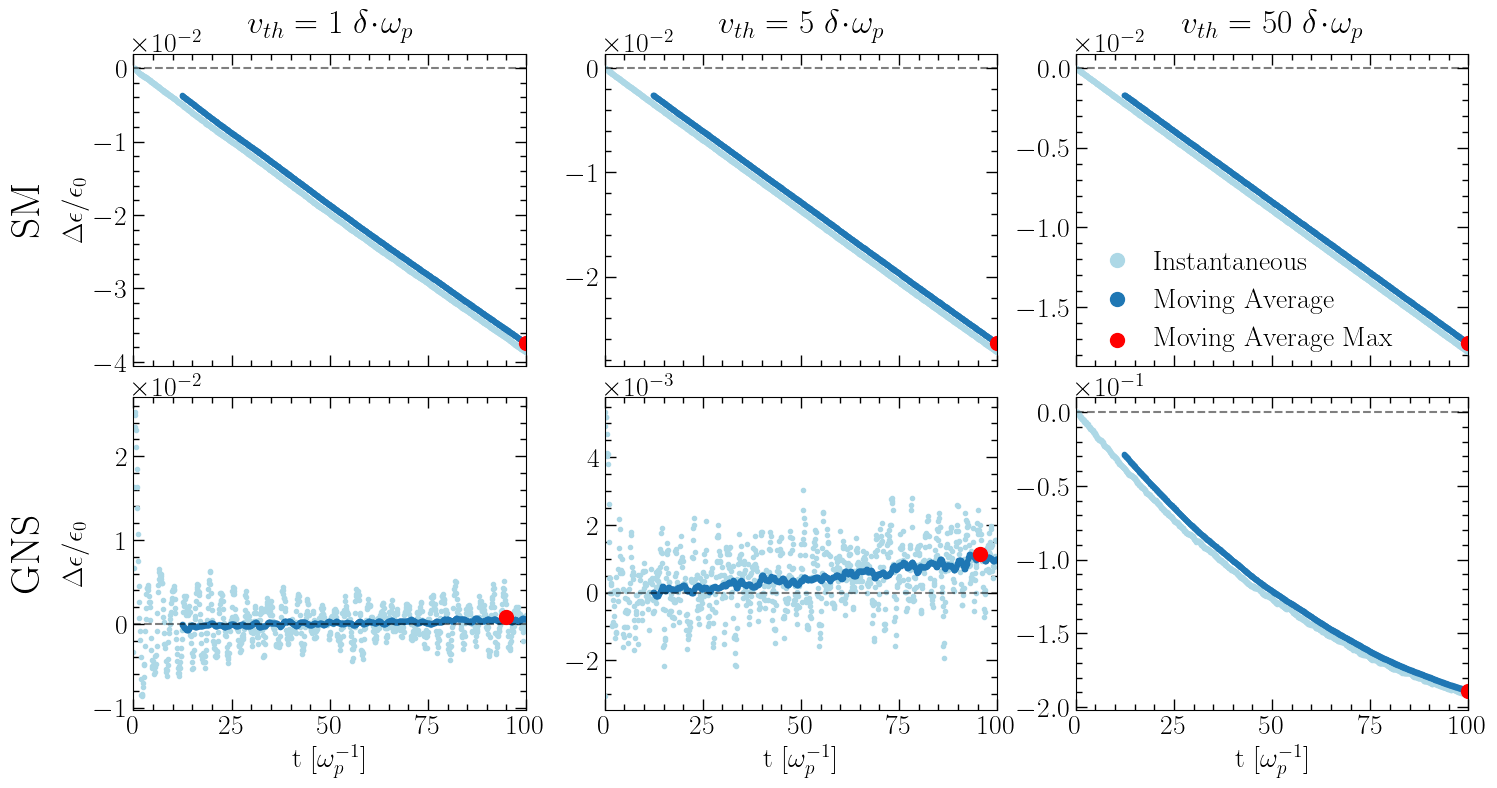

In [20]:
fig, ax = plt.subplots(2, len(V_TH), figsize=(5*len(V_TH),4*2),
                       gridspec_kw={'wspace':0.20, 'hspace':0.10, 'left': 0.09, 'right': 0.98, 
                                    'top': 0.92, 'bottom': 0.10}, 
                       sharex=True)

t = np.linspace(0,t_max, len(E_gns))
w_ma = int(2*np.pi/opt['dt'])
n_skip = int(2*np.pi/opt['dt'])

for im, (model, E_hist) in enumerate([['Sheet Model', E_sm_hist], ['GNS', E_gns_hist]]):
    for iv, E in enumerate(E_hist):
        
        E0 = E_sm_hist[iv][0]
            
        E_ma = moving_average((E[n_skip:] - E0)/E0, w_ma) 

        E_ma_max = np.max(E_ma)
        E_ma_min = np.min(E_ma)

        ax[im, iv].plot(t, (E - E0)/E0, '.', c='lightblue', label='Instantaneous', rasterized=True)
        ax[im, iv].plot(t[w_ma-1+n_skip:], E_ma, '.', label='Moving Average', rasterized=True)
        
        ax[im, iv].axhline(0, c='k', ls='--', alpha=0.5) 
        
        ax[im, iv].scatter(t[w_ma-1+np.argmax(np.abs(E_ma))+n_skip],
                           E_ma_max if E_ma_max > - E_ma_min else E_ma_min, 
                           c='r', s=100, label='Moving Average Max',
                           zorder=2)
        

for i, a in enumerate(ax[0]):
    a.set_title('$v_{th} = $ ' + f'{V_TH[i]:.0f} ' + ' $\delta\!\cdot\!\omega_p$', pad=15)
    
for a in ax.ravel():
    a.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
    
        
plt.setp(ax[1], xlabel='t [$\omega_p^{-1}$]')
plt.setp(ax[:,0], ylabel='$\Delta\epsilon/\epsilon_0$')

plt.xlim(0, t_max)
lgnd = ax[0,-1].legend(loc='lower left', borderpad=0, borderaxespad=0.5, framealpha=0)
lgnd.legendHandles[0].set_markersize(20)
lgnd.legendHandles[1].set_markersize(20)

fig.text(0.02, 0.725, 'SM',
         rotation=90,
         horizontalalignment='center',
         verticalalignment='center',
         multialignment='center',
         fontsize=30,
         fontweight='bold')

fig.text(0.02, 0.295, 'GNS',
         rotation=90,
         horizontalalignment='center',
         verticalalignment='center',
         multialignment='center',
         fontsize=30,
         fontweight='bold')

plt.savefig('../img/benchmark_energy_conservation_ex.pdf')
plt.show()

In this case we get the correct estimation for the energy conservation. There is not initial jump in the relative energy variation for the GNS since both the correct initial energy is used (the one from the Sheet Model) + the system initial conditions are equivalent (correct initial finite difference velocities are used for the GNS).

We also skip the first plasma oscillation, due to the initial larger oscillation (first time steps) caused by the finite difference velocities prior to crossings.